# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# load data and create pandas table

In [2]:
job_name = "new_targets"
res = pd.read_pickle(job_name+"_results")

In [3]:
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,0.015114,"[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.740137,0.068111,3.081603,NaN,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.00100,0.187302,"[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",1.495525,0.081860,3.703672,23.928402,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
2,1,0.50,64,2,0.00100,0.641077,"[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[5.900314, 0.071930945, 2.444656, 0.3109925, 0...",2.934705,0.106424,4.815017,11.738821,"[[0.16980672, 0.03534209, -5.743517, -1.928969...","[927.6387, 39.972656, 27.728518, 25.279482, 16...","[[-0.0153085105], [-0.019875195], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,2.281639,"[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[21.524408, 8.16959, 1.6052701, 0.0001602823, ...",8.182631,0.274457,12.417486,8.182631,"[[0.2108666, -0.38957053, -6.2587175, -2.36097...","[900.4196, 79.50415, 55.996628, 49.58121, 23.3...","[[-0.033807214], [-0.022455966], [0.5842638], ...",0.166716,9.596908
4,1,0.00,64,2,0.00010,0.028895,"[60.26413, 60.159615, 60.05532, 59.95124, 59.8...","[1340.8729, 1340.8097, 1340.7502, 1340.6937, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.5423617, 0.00019514473, 0.10284095, 0.03414...",0.928619,0.068483,3.098423,NaN,"[[-0.018078368, 0.014159506, -6.263246, -1.764...","[960.09735, 11.421275, 9.020982, 3.8924668, 3....","[[0.0042218138], [-0.01283936], [0.59729654], ...",0.014436,0.827163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,5,1.00,2048,9,0.00010,2.432432,"[236.30975, 208.86887, 210.2425, 206.75482, 20...","[29501.82, 29509.861, 29513.518, 29508.615, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.25559276, 10.329366, 0.9790047, 3.8081436, ...",6.782414,0.246251,11.141313,6.782414,"[[-21.921944, -18.711365, 10.076048, -7.721287...","[4749.2397, 2246.7466, 1056.1708, 913.77637, 3...","[[0.1524885, 0.0037291914, 0.25108734, -0.1343...",0.189280,10.910785
1724,5,0.00,2048,9,0.00001,0.000050,"[232.25053, 207.80002, 209.80006, 205.82233, 2...","[29513.32, 29520.557, 29524.723, 29519.812, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[2.8930663e-05, 2.081638e-05, 1.3174609e-05, 4...",0.000166,0.000022,0.001010,NaN,"[[-27.680054, -27.324131, 9.983265, -0.3400538...","[4699.833, 2158.7092, 959.5507, 783.98596, 113...","[[0.15131909, 0.0054286965, 0.2565511, -0.1155...",0.000398,0.022828
1725,5,0.25,2048,9,0.00001,0.140439,"[232.98697, 207.87595, 209.74756, 205.85141, 2...","[29512.914, 29520.34, 29524.424, 29519.537, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[1.0901405, 0.384014, 0.07075234, 1.7803897, 0...",0.338081,0.013457,0.608828,5.409295,"[[-26.25494, -23.981861, 9.65

# Check if Final Training Loss is Okay

In [4]:
trainMSE_threshold=1e-2
assert sum(res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]) == 0

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [5]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                       0.00001   0.00010   0.00100
r sigma n    L Activations                              
1 0.0   64   2 standard     0.458752  0.030106  0.016170
             3 standard     0.070858  0.002051  0.018850
             4 standard     0.190729  0.001041  0.000932
             5 standard     0.564625  0.000791  0.000715
             6 standard     0.665944  0.008138  0.000706
...                              ...       ...       ...
5 1.0   2048 5 standard     1.862567  1.802698  1.830375
             6 standard     1.800133  1.851761  2.121804
             7 standard     1.725311  1.894815  2.519768
             8 standard     1.864483  2.089984  2.278860
             9 standard     2.289828  2.645401  2.333031

[576 rows x 3 columns]

In [6]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n     L  Activations
1  0.00   64    2  standard       0.00100
                3  standard       0.00010
                4  standard       0.00100
                5  standard       0.00100
                6  standard       0.00100
                7  standard       0.00100
                8  standard       0.00100
                9  standard       0.00100
          128   2  standard       0.00100
                3  standard       0.00010
                4  standard       0.00010
                5  standard       0.00010
                6  standard       0.00010
                7  standard       0.00010
                8  standard       0.00010
                9  standard       0.00010
          256   2  standard       0.00100
                3  standard       0.00010
                4  standard       0.00010
                5  standard       0.00010
                6  standard       0.00010
                7  standard       0.00010
                8  standard       0.00010
   

In [7]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,0.015114,"[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.740137,0.068111,3.081603,NaN,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.00100,0.187302,"[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",1.495525,0.081860,3.703672,23.928402,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
2,1,0.50,64,2,0.00100,0.641077,"[60.23307, 60.129654, 60.026463, 59.923485, 59...","[1340.8153, 1340.6946, 1340.5769, 1340.463, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[5.900314, 0.071930945, 2.444656, 0.3109925, 0...",2.934705,0.106424,4.815017,11.738821,"[[0.16980672, 0.03534209, -5.743517, -1.928969...","[927.6387, 39.972656, 27.728518, 25.279482, 16...","[[-0.0153085105], [-0.019875195], [0.5910878],...",0.086960,4.988720
3,1,1.00,64,2,0.00100,2.281639,"[60.6362, 60.53386, 60.43174, 60.32984, 60.228...","[1340.8146, 1340.6935, 1340.5748, 1340.4594, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[21.524408, 8.16959, 1.6052701, 0.0001602823, ...",8.182631,0.274457,12.417486,8.182631,"[[0.2108666, -0.38957053, -6.2587175, -2.36097...","[900.4196, 79.50415, 55.996628, 49.58121, 23.3...","[[-0.033807214], [-0.022455966], [0.5842638], ...",0.166716,9.596908
14,1,0.50,64,3,0.00100,0.702132,"[59.98826, 59.507004, 59.033882, 58.570343, 58...","[3341.6108, 3341.4773, 3341.4646, 3341.5679, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[2.985103, 0.3172814, 2.5259962, 0.44516805, 1...",3.793227,0.148085,6.699946,15.172910,"[[-0.19413537, 0.11553269, -6.6518807, -2.1534...","[952.00824, 61.491272, 35.12933, 24.88408, 5.0...","[[0.017059596], [0.009166015], [-0.59270257], ...",0.092160,5.287869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,5,1.00,2048,8,0.00001,1.749005,"[244.71646, 210.84593, 209.92616, 214.91696, 2...","[23538.053, 23555.135, 23549.713, 23556.451, 2...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[1.8163214, 5.2062883, 0.15353708, 0.017697979...",4.146415,0.131436,5.946648,4.146415,"[[-30.22099, -23.40977, 12.5763645, 2.5454693,...","[4661.8423, 2086.694, 908.10657, 722.39594, 11...","[[0.15096115, 0.0044920933, 0.25187856, -0.097...",0.172054,9.907251
1717,5,0.25,2048,9,0.00100,0.103449,"[233.22961, 207.89597, 209.71574, 205.8718, 20...","[29453.945, 29459.85, 29462.041, 29455.156, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.016500974, 0.6785757, 0.06134571, 0.1103308...",0.186107,0.006632,0.300046,2.977709,"[[-27.786797, -25.46785, 9.91794, -0.6293863, ...","[4693.2944, 2150.9504, 949.2803, 772.80206, 11...","[[0.15082245, 0.005449582, 0.25789315, -0.1123...",0.040777,2.336985
1718,5,0.50,2048,9,0.00100,0.522456,"[234.17577, 208.1007, 209.75089, 206.04716, 20...","[29453.639, 29459.742, 29461.852, 29455.012, 2...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.38082623, 1.8808129e-07, 0.37176108, 0.9628...",1.277195,0.048017,2.172480,5.108779,"[[-27.210886, -22.6

##  determine the L parameter that gets the best validation MSE for each (r,n)

In [8]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
bestL = validationmse_vs_L.idxmin(axis=1)
pd.concat((validationmse_vs_L,bestL),axis=1)

3          4          5          6  \
r sigma n    Activations                                               
1 0.0   64   standard      0.002051   0.000932   0.000715   0.000706   
        128  standard      0.000425   0.000206   0.000129   0.000142   
        256  standard      0.000193   0.000064   0.000044   0.000055   
        512  standard      0.000141   0.000071   0.000049   0.000044   
        1024 standard      0.000167   0.000080   0.000056   0.000052   
...                             ...        ...        ...        ...   
5 1.0   128  standard     24.014839  36.260094  32.339001  31.649864   
        256  standard      5.036283   3.102456   3.027891   3.116910   
        512  standard      2.776951   2.600119   2.493171   2.555466   
        1024 standard      2.269037   2.079994   2.001227   1.993765   
        2048 standard      2.215496   1.986865   1.802698   1.800133   

                                  7          8          9  0  
r sigma n    Activations                                      
1 0.0   64   standard      0.000597   0.000566   0.000451  9  
        128  standard      0.000204   0.000138   0.000195  5  
        256  standard      0.000052   0.000056   0.000049  5  
        512  standard      0.000044   0.000047   0.000028  9  
        1024 standard      0.000016   0.000013   0.000017  8  
...                             ...        ...        ... ..  
5 1.0   128  standard     40.054626  38.297050  43.558807  3  
        256  standard      3.823605   5.628647   3.873743  5  
        512  standard      2.496893   2.693897   2.571741  5  
        1024 standard      1.932676   1.970758   2.139271  7  
        2048 standard      1.725311   1.864483   2.289828  7  

[72 rows x 8 columns]

In [9]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
25,1,0.25,64,4,0.00100,0.176464,"[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.689151,0.024729,1.118811,11.026415,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
27,1,1.00,64,4,0.00100,2.341421,"[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[22.790386, 4.445869, 5.3361945, 0.086147115, ...",6.998349,0.232031,10.497951,6.998349,"[[0.77333224, 0.22412235, -7.0918145, -3.65294...","[956.0663, 99.418846, 85.08017, 57.991444, 2.0...","[[-0.044039372], [0.01136637], [0.59848475], [...",0.170056,9.791063
30,1,0.50,64,4,0.00010,0.630799,"[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.014794252, 0.14083554, 0.7016484, 0.0180359...",2.070236,0.066815,3.022980,8.280945,"[[0.16648225, 0.20393237, -5.1484613, -1.70353...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
84,1,0.00,64,9,0.00100,0.000463,"[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.004198,0.000324,0.014646,NaN,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
119,1,1.00,128,3,0.00001,1.822912,"[49.669785, 49.001053, 48.34638, 47.70898, 47....","[3341.9082, 3342.2773, 3342.9736, 3343.984, 33...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.572354, 0.23592384, 4.638374, 0.2746769, 0...",4.770700,0.147449,6.671156,4.770700,"[[-0.7596836, -0.17297879, -5.5984225, -1.1514...","[949.2189, 87.633156, 82.270195, 45.703335, 42...","[[0.0022033267], [0.00783493], [-0.584617], [-...",0.084273,4.834193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,5,1.00,1024,7,0.00010,1.794802,"[984.8106, 279.8098, 226.3757, 201.96754, 204....","[18076.688, 18276.637, 18268.473, 18253.672, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[7.818072, 3.4109757, 0.22896078, 2.4932485, 0...",4.690493,0.159483,7.215624,4.690493,"[[-28.165638, -25.364431, 11.773777, 0.1994543...","[4653.3086, 2075.05, 913.0427, 726.42804, 119....","[[0.14915799, 0.008020752, 0.25940505, -0.0947...",0.237608,13.745428
1669,5,0.25,2048,5,0.00100,0.088788,"[700.7898, 208.43573, 198.9562, 188.35312, 152...","[9515.913, 9724.882, 9744.835, 9770.905, 9826....","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.1454435, 0.34681636, 0.084018685, 0.4041293...",0.164731,0.006240,0.282320,2.635692,"[[-27.481844, -26.322382, 9.562078, -0.7019545...","[4693.5327, 2149.989, 953.1619, 773.29034, 109...","[[0.15103607, 0.005889602, 0.25830093, -0.1100...",0.036600,2.097469
1672,5,0.00,2048,5,0.00010,0.000019,"[700.7407, 208.35342, 198.8359, 188.06416, 151...","[9520.94, 9730.505, 9751.47, 9778.157, 9834.99...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[3.274181e-05, 3.810042e-06, 8.152743e-06, 7.2...",0.000076,0.000016,0.000711,NaN,"[[-27.68298, -27.32

In [10]:
bestLres.sort_values(by=['r','n',"sigma"])

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
84,1,0.00,64,9,0.00100,0.000463,"[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.004198,0.000324,0.014646,NaN,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
25,1,0.25,64,4,0.00100,0.176464,"[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.689151,0.024729,1.118811,11.026415,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
30,1,0.50,64,4,0.00010,0.630799,"[59.867638, 59.306477, 58.756195, 58.20883, 57...","[6010.1333, 6010.482, 6011.1475, 6012.1177, 60...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.014794252, 0.14083554, 0.7016484, 0.0180359...",2.070236,0.066815,3.022980,8.280945,"[[0.16648225, 0.20393237, -5.1484613, -1.70353...","[956.5194, 64.51156, 43.482506, 26.711407, 7.5...","[[-0.017127283], [-0.011515118], [0.5929013], ...",0.079817,4.578033
27,1,1.00,64,4,0.00100,2.341421,"[60.256546, 59.695442, 59.145172, 58.59809, 58...","[6009.6245, 6009.4707, 6009.6377, 6010.1157, 6...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[22.790386, 4.445869, 5.3361945, 0.086147115, ...",6.998349,0.232031,10.497951,6.998349,"[[0.77333224, 0.22412235, -7.0918145, -3.65294...","[956.0663, 99.418846, 85.08017, 57.991444, 2.0...","[[-0.044039372], [0.01136637], [0.59848475], [...",0.170056,9.791063
136,1,0.00,128,5,0.00010,0.000121,"[48.925003, 48.27504, 47.552925, 46.661526, 45...","[9343.715, 9345.677, 9349.422, 9354.756, 9361....","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[2.8298095e-05, 0.00043059408, 0.00035353936, ...",0.005129,0.000503,0.022736,NaN,"[[-0.08770336, 0.11391217, -6.4779854, -1.7641...","[980.75745, 0.008354146, 0.00040266901, 8.0927...","[[0.008103928], [-0.0105216345], [0.59816086],...",0.000731,0.041886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,5,1.00,1024,7,0.00010,1.794802,"[984.8106, 279.8098, 226.3757, 201.96754, 204....","[18076.688, 18276.637, 18268.473, 18253.672, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[7.818072, 3.4109757, 0.22896078, 2.4932485, 0...",4.690493,0.159483,7.215624,4.690493,"[[-28.165638, -25.364431, 11.773777, 0.1994543...","[4653.3086, 2075.05, 913.0427, 726.42804, 119....","[[0.14915799, 0.008020752, 0.25940505, -0.0947...",0.237608,13.745428
1672,5,0.00,2048,5,0.00010,0.000019,"[700.7407, 208.35342, 198.8359, 188.06416, 151...","[9520.94, 9730.505, 9751.47, 9778.157, 9834.99...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[3.274181e-05, 3.810042e-06, 8.152743e-06, 7.2...",0.000076,0.000016,0.000711,NaN,"[[-27.68298, -27.328796, 9.98303, -0.3313164, ...","[4699.344, 2158.738, 960.6782, 785.0251, 113.2...","[[0.15131909, 0.005679825, 0.2564762, -0.11575...",0.000328,0.018801
1669,5,0.25,2048,5,0.00100,0.088788,"[700.7898, 208.43573, 198.9562, 188.35312, 152...","[9515.913, 9724.882, 9744.835, 9770.905, 9826....","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.1454435, 0.34681636, 0.084018685, 0.4041293...",0.164731,0.006240,0.282320,2.635692,"[[-27.481844, -26.322382

## What are the chosen lambda and L for each model?

In [11]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bestres.loc[:,:"lambda"].pivot_table(index=["r","sigma","n","L"],values=["lambda"]))

lambda
r sigma n    L         
1 0.00  64   2  0.00100
             9  0.00100
        128  2  0.00100
             5  0.00010
        256  2  0.00100
             5  0.00010
        512  2  0.00010
             9  0.00001
        1024 2  0.00010
             8  0.00001
        2048 2  0.00010
             8  0.00001
  0.25  64   2  0.00100
             4  0.00100
        128  2  0.00100
             4  0.00100
        256  2  0.00100
             7  0.00001
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  0.50  64   2  0.00100
             4  0.00010
        128  2  0.00100
             4  0.00100
        256  2  0.00100
             7  0.00001
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  1.00  64   2  0.00100
             4  0.00100
        128  2  0.00100
             3  0.00001
        256  2  0.00100
             8  0.00001
        512  2  0.00100
             8  0.00001
        1024 2  0.00100
             8  0.00001
        2048 2  0.00100
             9  0.00100
2 0.00  64   2  0.00010
             7  0.00100
        128  2  0.00100
             9  0.00100
        256  2  0.00100
             9  0.00100
        512  2  0.00100
             9  0.00010
        1024 2  0.00100
             8  0.00001
        2048 2  0.00100
             7  0.00001
  0.25  64   2  0.00010
             9  0.00001
        128  2  0.00100
             9  0.00100
        256  2  0.00010
             9  0.00100
        512  2  0.00100
             9  0.00100
        1024 2  0.00100
             8  0.00100
        2048 2  0.00100
             5  0.00100
  0.50  64   2  0.00010
             8  0.00100
        128  2  0.00100
             8  0.00100
        256  2  0.00100
             6  0.00100
        512  2  0.00100
             7  0.00010
        1024 2  0.00100
             9  0.00100
        2048 2  0.00100
             9  0.00100
  1.00  64   2  0.00100
             5  0.00001
        128  2  0.00010
             9  0.00001
        256  2  0.00100
             8  0.00001
        512  2  0.00100
             9  0.00001
        1024 2  0.00010
             9  0.00100
        2048 2  0.00100
             9  0.00100
5 0.00  64   2  0.00100
             3  0.00100
        128  2  0.00010
             3  0.00100
        256  2  0.00100
             5  0.00100
        512  2  0.00100
             8  0.00100
        1024 2  0.00100
             6  0.00010
        2048 2  0.00010
             5  0.00010
  0.25  64   2  0.00100
             3  0.00100
        128  2  0.00010
             3  0.00100
        256  2  0.00100
             5  0.00100
        512  2  0.00100
             7  0.00100
        1024 2  0.00100
             7  0.00100
        2048 2  0.00100
             5  0.00100
  0.50  64   2  0.00100
             3  0.00100
        128  2  0.00010
             3  0.00100
        256  2  0.00100
             5  0.00100
        512  2  0.00100
             7  0.00100
        1024 2  0.00100
             7  0.00010
        2048 2  0.00100
             7  0.00100
  1.00  64   2  0.00100
             3  0.00100
        128  2  0.00010
             3  0.00100
        256  2  0.00100
             5  0.00010
        512  2  0.00100
             5  0.00100
        1024 2  0.00100
             7  0.00010
        2048 2  0.00100
             7  0.00001

# Plotting

In [13]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## plots of all the singular values

1,64,2 [2.1397243e+01 2.4623199e-01 6.6962458e-02 3.9176621e-02 2.7920175e-02
 1.5365248e-02 1.0518808e-02 8.0341594e-03 4.3791197e-03 3.1832876e-03
 2.1692181e-03 8.1623532e-04 6.0984632e-04 3.3214863e-04 2.0764796e-04
 4.0772051e-05 3.2469794e-05 1.5392319e-05 1.3646404e-05 4.2827833e-06] 0 0
1,64,3 [2.1580151e+01 5.4735214e-02 2.4986418e-02 1.2170918e-02 7.5046243e-03
 1.6577423e-03 5.0423417e-04 2.4053176e-04 1.2748704e-04 6.4061038e-05
 2.4790335e-05 4.9130044e-06 2.9639423e-06 1.2934518e-06 9.0640413e-07
 4.7738229e-07 2.2277638e-07 9.8542273e-08 5.7503907e-08 5.3293949e-08] 0 0
1,64,4 [2.1628813e+01 5.1748168e-07 2.8420374e-07 2.2149433e-07 1.9740760e-07
 1.5282292e-07 1.2953493e-07 8.5448434e-08 7.2132302e-08 5.9907968e-08
 5.5161298e-08 5.0762296e-08 3.7802067e-08 3.0257148e-08 2.2989834e-08
 2.0959433e-08 8.3080103e-09 4.5034780e-09 3.5534113e-09 2.7133789e-09] 0 0
1,64,5 [2.16645317e+01 6.98433496e-07 4.17069828e-07 2.63438011e-07
 2.22102358e-07 1.44807771e-07 1.11980754e-0

/tmp/ipykernel_2243905/406956267.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


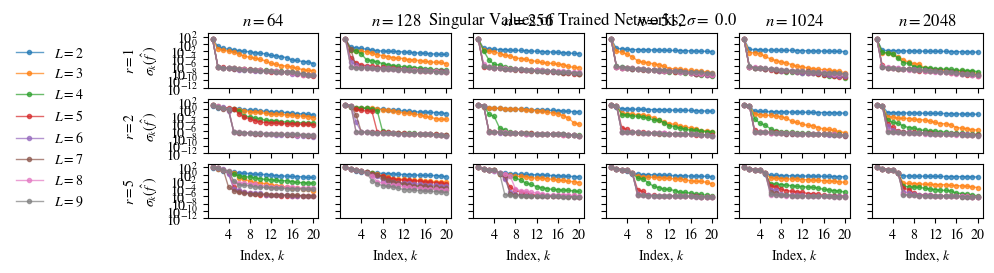

1,64,2 [2.0923059e+01 4.7731632e-01 3.2848510e-01 2.7345777e-01 2.3200534e-01
 1.0044924e-01 6.4735457e-02 4.6735670e-02 4.1192871e-02 2.8033506e-02
 1.8110830e-02 1.4201348e-02 1.2294594e-02 8.5400902e-03 7.8599583e-03
 5.6151007e-03 2.6779012e-03 2.1586404e-03 1.7372592e-03 1.1288283e-03] 0 0
1,64,3 [2.1120762e+01 8.1277418e-01 4.3553779e-01 1.8993248e-01 1.4589723e-02
 3.6647595e-03 3.0990695e-03 9.3590934e-04 3.0622090e-04 1.8559968e-04
 8.2383602e-05 5.2396066e-05 2.9655492e-05 1.0400398e-05 7.3838660e-06
 4.1860367e-06 2.6331572e-06 2.0345165e-06 5.5021832e-07 2.8727544e-07] 0 0
1,64,4 [2.13512039e+01 1.05664647e+00 3.87968063e-01 6.02444075e-02
 1.51315862e-06 6.89528690e-07 4.95657389e-07 3.95214130e-07
 2.41935908e-07 2.23807589e-07 1.51665404e-07 1.42781886e-07
 1.21754141e-07 1.11776515e-07 9.98448400e-08 9.17864398e-08
 5.67596707e-08 5.25528527e-08 4.92175403e-08 3.79793548e-08] 0 0
1,64,5 [2.1502148e+01 1.4847531e+00 5.0623465e-01 6.5863406e-07 4.4564078e-07
 3.4782155e-0

/tmp/ipykernel_2243905/406956267.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


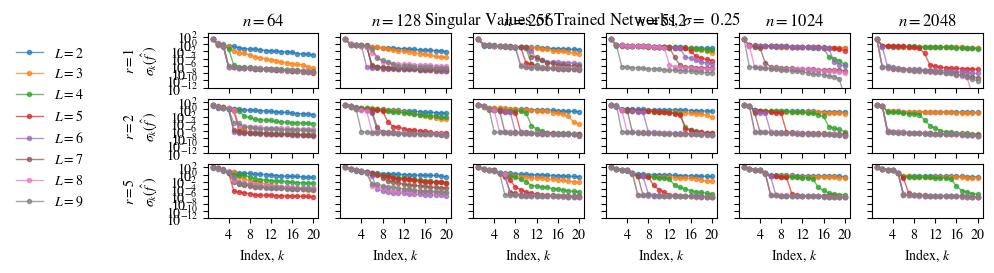

1,64,2 [2.04981136e+01 8.83279264e-01 6.12719476e-01 5.58602929e-01
 3.55309188e-01 1.78187162e-01 1.19499475e-01 8.90742540e-02
 5.59838004e-02 3.77760306e-02 3.59509103e-02 2.44974457e-02
 2.15893555e-02 1.51047707e-02 1.22343199e-02 1.02405464e-02
 6.80851936e-03 5.42348670e-03 4.29125410e-03 2.63611344e-03] 0 0
1,64,3 [2.1036610e+01 1.3587780e+00 7.7625585e-01 5.4986572e-01 1.1215372e-01
 2.2409708e-04 4.3815409e-05 2.0851608e-05 1.9211750e-05 2.5293944e-06
 1.3398212e-06 6.7276301e-07 3.8060926e-07 3.2133877e-07 2.7117366e-07
 1.6830029e-07 1.3048266e-07 1.0129434e-07 8.5281513e-08 7.4139457e-08] 0 0
1,64,4 [2.1136293e+01 1.4255176e+00 9.6083671e-01 5.9024429e-01 1.6778463e-01
 5.8424450e-04 2.6702433e-04 8.2682796e-05 4.6563666e-05 1.5254790e-05
 8.4282865e-06 3.2350958e-06 2.3096070e-06 1.5274011e-06 5.4598837e-07
 4.1973411e-07 2.4407160e-07 1.3620500e-07 8.6701021e-08 7.1504587e-08] 0 0
1,64,5 [2.1225174e+01 3.2816470e+00 1.2820210e+00 5.3227080e-07 4.4093551e-07
 3.4827318e-0

/tmp/ipykernel_2243905/406956267.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


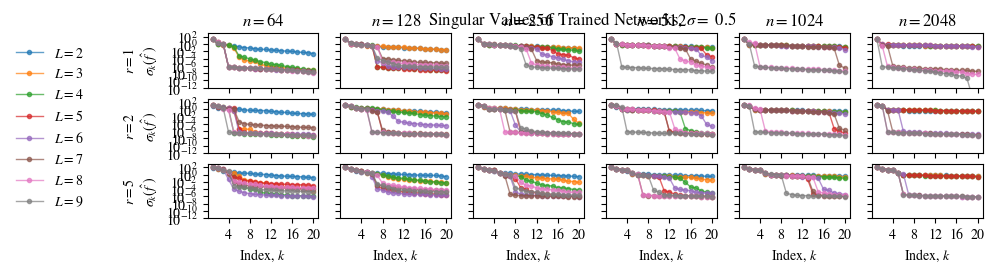

1,64,2 [1.9896650e+01 1.7568102e+00 1.2373624e+00 1.0956004e+00 5.1486474e-01
 2.6351553e-01 2.2440799e-01 1.6364118e-01 8.7633409e-02 7.9600602e-02
 6.4675041e-02 6.1927229e-02 4.1482087e-02 3.1258203e-02 1.8352002e-02
 1.6519925e-02 1.3674894e-02 1.0709276e-02 8.4582623e-03 7.4870642e-03] 0 0
1,64,3 [2.05218182e+01 1.55662858e+00 1.19362175e+00 1.01232624e+00
 8.96697640e-01 4.47575182e-01 2.26720974e-01 1.88756287e-01
 1.01232246e-01 8.62021819e-02 6.06710277e-02 5.11917211e-02
 3.57047170e-02 3.37310582e-02 2.50764843e-02 2.02342290e-02
 1.57400537e-02 1.25546223e-02 1.11211352e-02 4.98044398e-03] 0 0
1,64,4 [2.1126280e+01 2.1968670e+00 1.8800240e+00 1.2814420e+00 4.4283553e-07
 3.4141277e-07 3.2496064e-07 2.4210593e-07 1.9713617e-07 1.6474144e-07
 1.6100701e-07 1.1941886e-07 1.1076586e-07 8.0224247e-08 6.6399842e-08
 5.7098486e-08 5.2379114e-08 4.2767642e-08 3.3876660e-08 2.8642940e-08] 0 0
1,64,5 [2.1206379e+01 3.5430894e+00 2.0663581e+00 8.7249058e-01 3.9499563e-01
 2.2775270e-0

/tmp/ipykernel_2243905/406956267.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


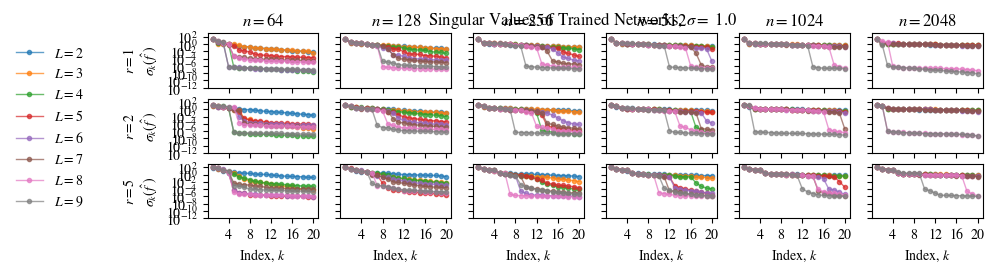

In [14]:
#all the singular values
for std in res.sigma.unique():
    f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,2.4))
    if len(res.r.unique()) == 1: ax = ax[np.newaxis]
    for rownum,row in res.iterrows():
        if row['sigma'] == std:
            whichrow = np.where(row['r'] == res.r.unique())[0][0]
            whichcol = np.where(row['n'] == res.n.unique())[0][0]
            print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
            ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
            ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
            ax[whichrow,whichcol].set_ylim(10**-9,10**3)
            ax[0,whichcol].set_title(rf"$n={row['n']}$")
            ax[-1,whichcol].set_xlabel(rf"Index, $k$")
    plt.subplot(len(res.r.unique()),len(res.n.unique()),1)
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(-1, 1))
    leg.get_frame().set_edgecolor('b')
    leg.get_frame().set_linewidth(0.0)
    for rnum,r in enumerate(res.r.unique()):
        plt.subplot(len(res.r.unique()),len(res.n.unique()),1+rnum*len(res.n.unique()))
        plt.ylabel(f"$r={r}$"+"\n"+r"$\sigma_k(\hat f)$")
        plt.yticks([10**p for p in range(-12,3,2)])
    plt.suptitle(rf"Singular Values of Trained Networks, $\sigma =$ {std}")
    plt.tight_layout()
    plt.savefig(job_name+f"_labelnoise{std}_sv.pdf",dpi=300)
    plt.show()

## Plots of L vs Validation error

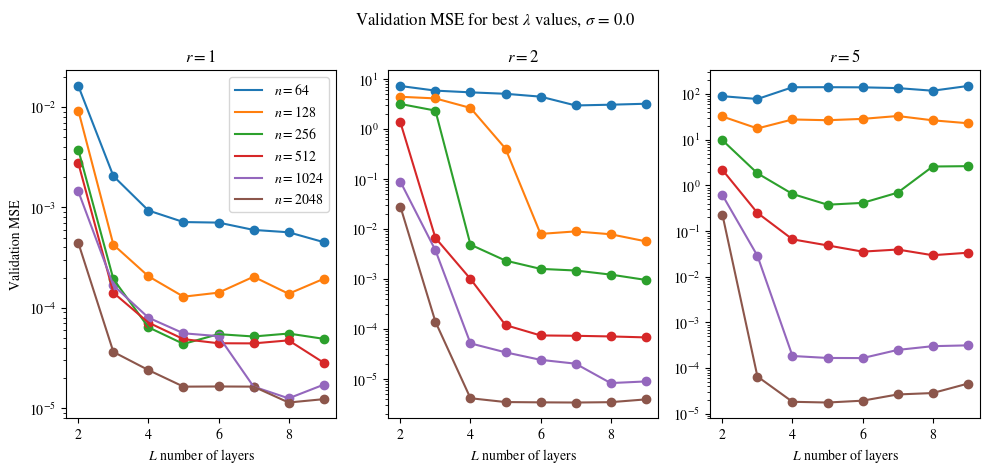

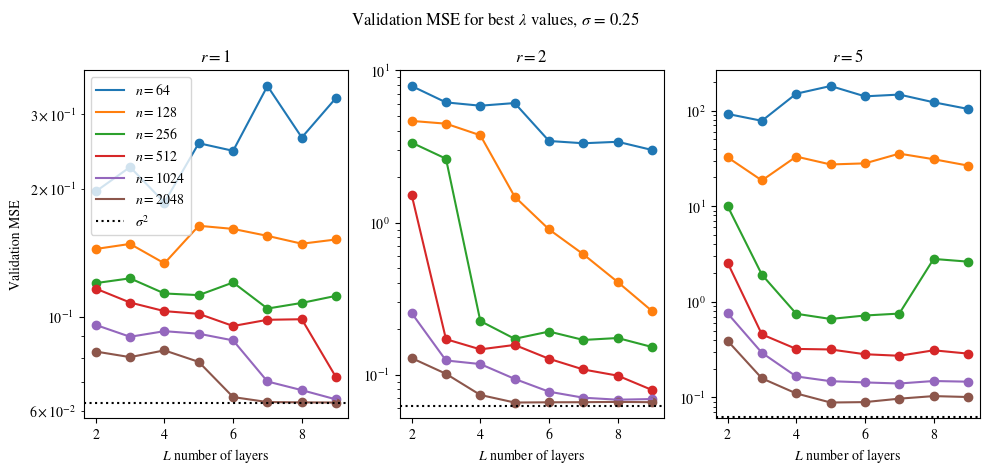

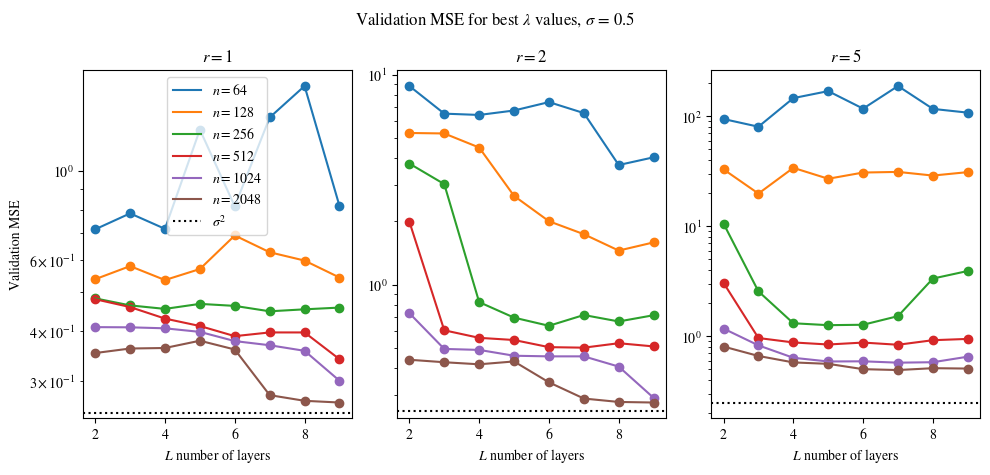

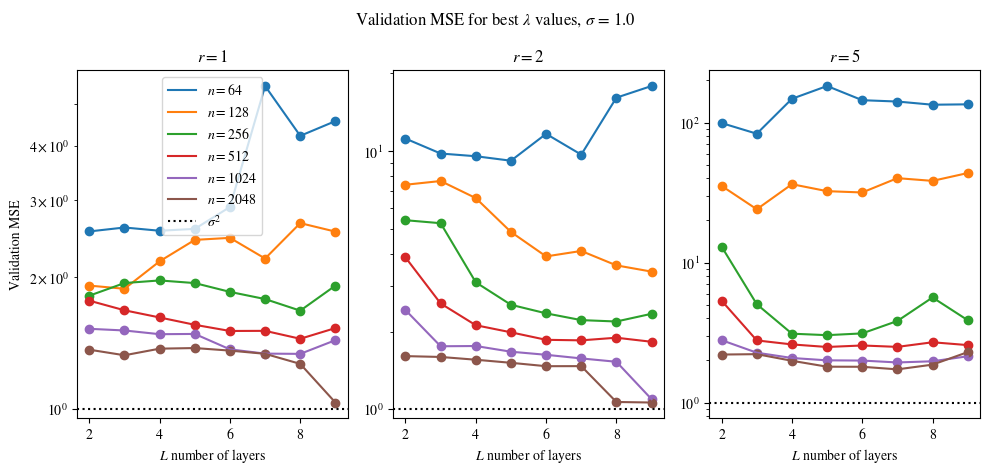

In [15]:
for std in res["sigma"].unique():
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=False, figsize=(10,4.8))
    if len(res.r.unique()) == 1: ax = [ax]
    for rnum,r in enumerate(res.r.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.r == r) * (res.n == n) * (res["sigma"] == std)]
                ax[rnum].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[rnum].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
                    # ax[rnum].annotate(text,[model.L,model[["Validation MSE"]]],fontsize=1)
        ax[rnum].set_xlabel("$L$ number of layers")
        ax[rnum].set_title(rf"$r={r}$")
        if std > 0:
            ax[rnum].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig(job_name+f"_labelnoise{std}_ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [16]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
    0.5 :"C2",
    1   :"C3"
}
labels = {
    "without extra layers":"-",
    "with extra layers"   :"--",
}
markers = {
    "without extra layers":".",
    "with extra layers"   :"x",
}

### generalization

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


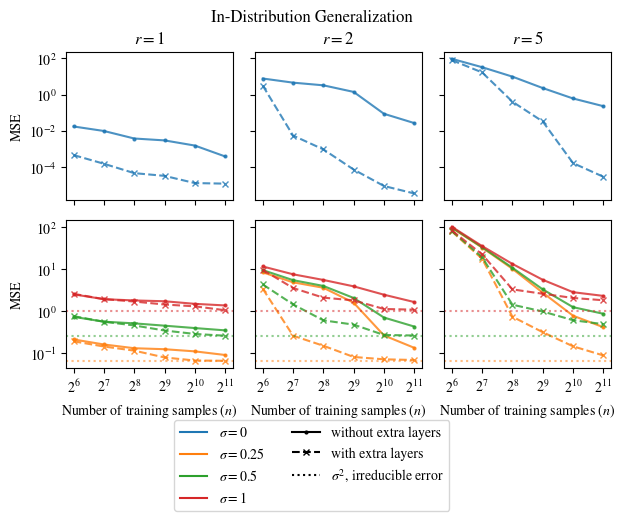

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


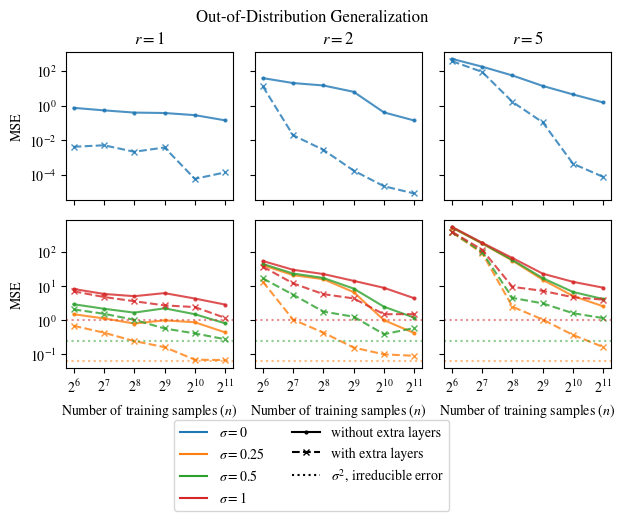

In [17]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution','Out-of-Distribution']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey="row", figsize=(columnwidth,4.25))
    if len(res.r.unique()) == 1: ax = ax[:,np.newaxis]
    #just the data without label noise in the first row
    for col,r in enumerate(res.r.unique()):
        for row,sigmas in enumerate([[0],[0.25,0.5,1]]):
            for sigma in sigmas:
                for label,ls in labels.items():
                    if label == "with extra layers":#"with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres["sigma"]==sigma)]
                    elif label == "without extra layers":#"without linear layers":
                        curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                    print(curr.shape)
                    points = curr[[metric + " MSE"]].values[:,0]
                    marker = markers[label]
                    ax[row,col].plot(curr.n,points,
                                        linestyle=ls,
                                        marker=marker,
                                        markersize=markersize,
                                        color=colors[sigma],
                                        alpha=0.8)
                    #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
                    ax[1,col].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
            #plot set up
            ax[row,col].set_xscale("log",base=2)
            ax[row,col].set_xticks([2**k for k in range(6,12)])
            ax[row,col].set_yscale("log",base=10)
            ax[row,0].set_ylabel(f"MSE",wrap=True)
            ax[0,col].set_title(rf"$r={r}$") 
            ax[1,col].set_xlabel("Number of training samples ($n$)")
            ax[row,col].minorticks_off()
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    plt.suptitle(f"{metric} Generalization")
    plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
    plt.savefig(job_name+f"{metric} Generalization.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

1 64 0 0
1 128 0 1
1 256 0 2
1 512 1 0
1 1024 1 1
1 2048 1 2
2 64 2 0
2 128 2 1
2 256 2 2
2 512 3 0
2 1024 3 1
2 2048 3 2
5 64 4 0
5 128 4 1
5 256 4 2
5 512 5 0
5 1024 5 1
5 2048 5 2


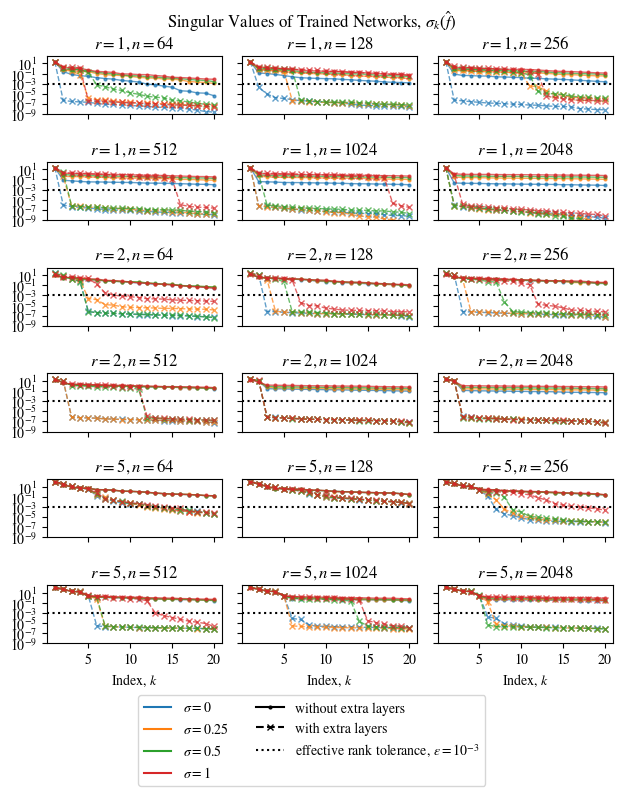

In [18]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=len(res.r.unique())*2, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,7))#,5.75))
for rnum,r in enumerate(res.r.unique()):
    for nnum,n in enumerate(res.n.unique()):
        row = 2*rnum + nnum // 3
        col = nnum % 3
        print(r,n,row,col)
        for sigma in res.sigma.unique():
            for label,ls in labels.items():
                if label == "with extra layers":#"with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres.n == n) * (bestLres["sigma"] == sigma)]
                elif label == "without extra layers":#"without linear layers":
                    curr = res[(res.L == 2) * (res.n == n) * (res.r == r) * (res["sigma"]==sigma)]
                marker = markers[label]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                    linestyle=ls,
                    linewidth=1,
                    alpha=0.7,
                    marker=marker,
                    markersize=markersize,
                    color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
        ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_title(rf"$r={r},n={n}$")
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f})$")
plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
plt.savefig(job_name+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0


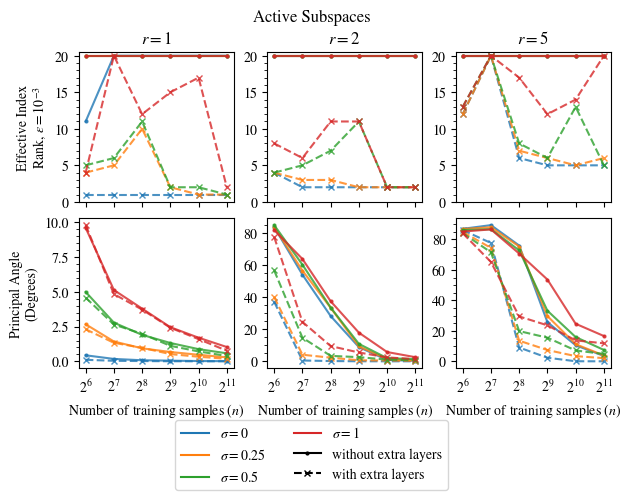

In [19]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey=False, figsize=(columnwidth,4.25))
if len(res.r.unique()) == 1: ax = ax[:,np.newaxis]
for row,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for col,r in enumerate(res.r.unique()):
        for sigma in res.sigma.unique():
            print(sigma)
            for label,ls in labels.items():
                if label == "with extra layers":#"with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                elif label == "without extra layers":#"without linear layers":
                    curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                if metric == "Principal Angle (Degrees)":
                    points = curr[[metric]].values[:,0]
                elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                    points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                    ax[row,col].set_yticks(np.arange(0,21,5))
                    ax[row,col].set_ylim(0,20.5)
                marker = markers[label]
                ax[row,col].plot(curr.n,points,
                                    linestyle=ls,
                                    color=colors[sigma],
                                    marker=marker,
                                    markersize=markersize,
                                    alpha=0.8)
                # for (_,model),y in zip(curr.iterrows(),points):
                #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
        #plot set up
        ax[row,0].set_ylabel(metric[:15] + '\n' + metric[16:])
        ax[0,col].set_title(rf"$r={r}$") 
        ax[0,col].set_yticks(range(21), minor=True)
        ax[row,col].set_xscale("log",base=2)
        ax[row,col].set_xticks([2**k for k in range(6,12)])
        ax[1,col].set_xlabel("Number of training samples ($n$)")
        ax[row,col].minorticks_on()
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(f"Active Subspaces")
plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
plt.savefig(job_name+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()